## El objetivo de este ejercicio es implementar Q-learning
<img src="https://github.com/javkrei/aprendizaje-reforzado-austral/blob/master/clase%205/Q-learning.PNG?raw=1">

**Para evitar que tengan problemas importando cosas que están en repositorio, directamente pueden correr las siguientes dos celdas (que contienen lo que originalmente se iba a importar de la carpeta lib)**

In [1]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [2]:
# Implementación del Cliff Walking

import numpy as np
import sys
from gym.envs.toy_text import discrete


UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class CliffWalkingEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta):
        new_position = np.array(current) + np.array(delta)
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        reward = -100.0 if self._cliff[tuple(new_position)] else -1.0
        is_done = self._cliff[tuple(new_position)] or (tuple(new_position) == (3,11))
        return [(1.0, new_state, reward, is_done)]

    def __init__(self):
        self.shape = (4, 12)

        nS = np.prod(self.shape)
        nA = 4

        # Cliff Location
        self._cliff = np.zeros(self.shape, dtype=np.bool)
        self._cliff[3, 1:-1] = True

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0])
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1])
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0])
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1])

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(CliffWalkingEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == (3,11):
                output = " T "
            elif self._cliff[position]:
                output = " C "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip() 
            if position[1] == self.shape[1] - 1:
                output = output.rstrip() 
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

In [3]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

#if "../" not in sys.path:
#  sys.path.append("../") 

from collections import defaultdict
#from lib.envs.cliff_walking import CliffWalkingEnv
#from lib import plotting

matplotlib.style.use('ggplot')

In [4]:
env = CliffWalkingEnv()

In [5]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Crea una política epsilon-greedy basado en una q-función (función de valor estado-acción) y un epsilon dados.
    
    Argumentos:
        Q: un diccionario que mapea cada estado/observación s a un array de numpy Q[s] = array([v_0, v_1, ... , v_nA]) de longitud nA
        que para un índice a del array contiene el valor v_a de tomar la acción a en el estado s. 
        (en nuestra notación de la clase q(s,a))
         
        epsilon: probabilidad de seleccionar una acción aleatoria (obliga a explorar), valor entre 0 y 1.
        
        nA: número de acciones en el entorno
    
    Retorna:
        Una función que dada una observación como argumento, retorna una política (un array de numpy de longitud nA)
        con probabilidades para cada acción. La política es tal que toma la mejor acción según Q con probabilidad (1-epsilon)
        y toma una acción al azar con probabilidad epsilon 
    """
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [6]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Algoritmo de Q-learning: Control TD off-policy. Encuentra la política greedy óptima mientras se comporta con una 
    política epsilon-greedy.
    
    Argumentos:
        env: ambiente de OpenAI.
        num_episodes: Número de episodios durante los cuales correr el algoritmo.
        discount_factor: factor de descuento gama.
        alpha: factor de aprendizaje TD.
        epsilon: Probabilidad de elegir una acción aleatoria. Entre 0 y 1.
    
    Retorna:
        Una tupla (Q, episode_lengths).
        Q es la función de valor estado-acción óptima
        Q es la función de valor estado-acción óptima, un diccionario que mapea estado -> array de valores para cada acción.
        stats es un objeto EpisodeStats con dos arrays numpy para longitud de episodios y longitud de recompensas.
    """
    
    # La función de valor estado-acción final (q-función final)
    #  un diccionario que mapea estado -> array de valores para cada acción.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # estadísticas útiles
#     stats = plotting.EpisodeStats(
#         episode_lengths=np.zeros(num_episodes),
#         episode_rewards=np.zeros(num_episodes))    
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    

    # la política que seguimos
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # printear cada 100 episodios
        if (i_episode + 1) % 100 == 0:
            print("\rEpisodio {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
            
        # Resetear el ambiente y elegir una primera acción
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # Relalizar un paso en el ambiente
        # total_reward = 0.0
        for t in itertools.count():
            
            # Tomar un paso
#             action_probs = policy(state)
#             action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # elegir próxima acción 
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

            # Actualizar las estadísticas
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Actualización TD
            best_next_action = np.argmax(Q[next_state])    
            ####### COMPLETAR #########
            Q[state][action] += alpha*( reward + discount_factor*Q[next_state][best_next_action] - Q[state][action] )
                
            if done:
                break
            
            action = next_action
            state = next_state
    
    return Q, stats

In [7]:
Q, stats = q_learning(env, 500)

Episodio 500/500.

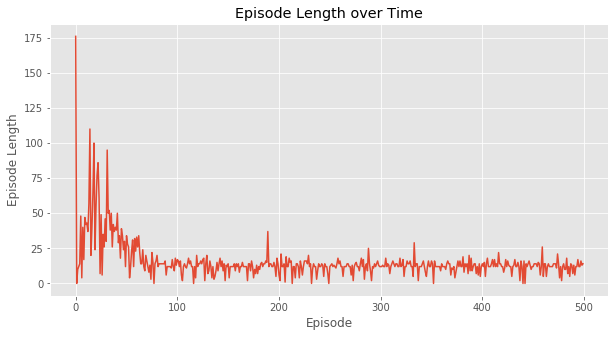

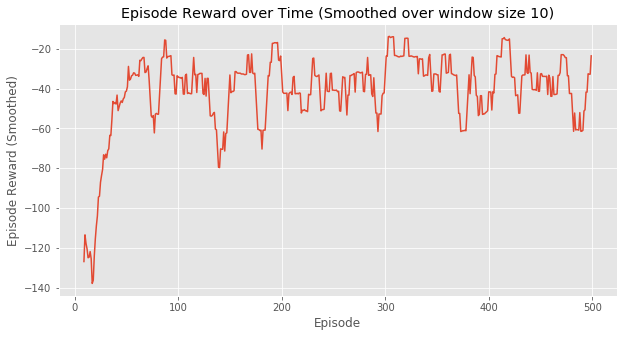

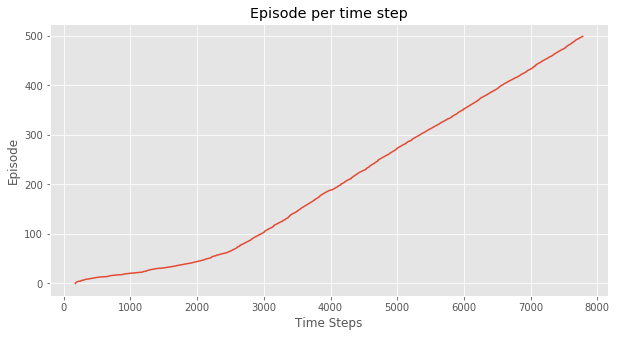

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [8]:
# plotting.plot_episode_stats(stats)
plot_episode_stats(stats)